<a href="https://colab.research.google.com/github/SaurabhChakravorty/SHALA2020/blob/master/Saurabh_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clustering Analysis

In [28]:
%%html
<marquee style='width: 100%; color: red;'><b><li style="font-size:75px;">Clustering</li></b></marquee>

In [2]:
# Load the file as a dataframe 
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Loading the data

In [4]:
df= pd.read_csv("/content/drive/My Drive/Colab Notebooks/assignment_shala_clustering.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
#print(df.shape)
#print(df.dtypes)
print(df.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [0]:
# Let's drop the id column as it makes no sense
df = df.drop(["CustomerID"], axis =1)

#### Descriptive statistics

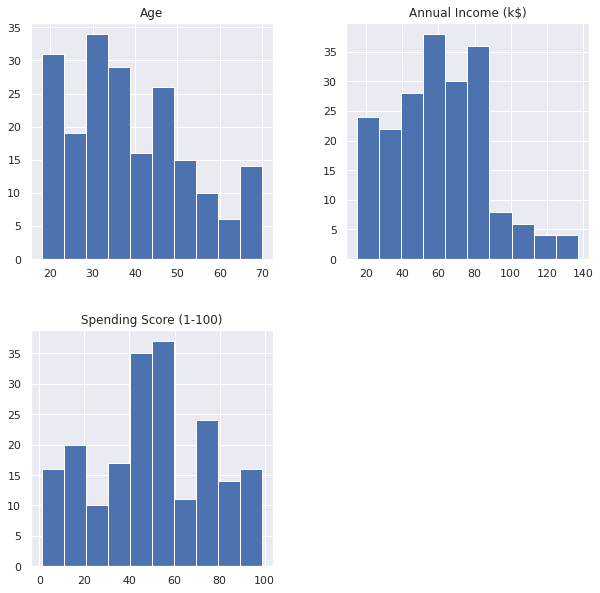

In [7]:
# Let's make a histogram
import matplotlib.pyplot as plt
df.hist(figsize=(10,10))
plt.show()

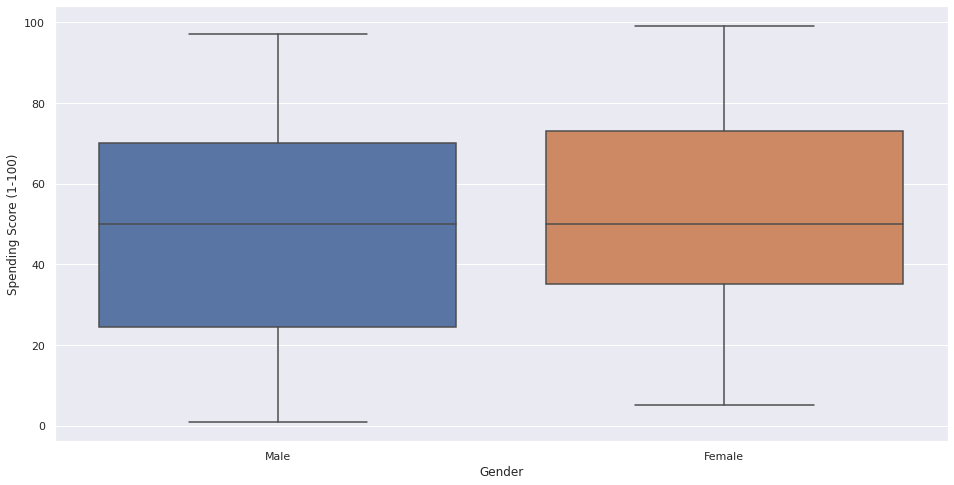

In [8]:
# Boxplot relation
import seaborn as sns
plt.figure(figsize=(16,8))
sns.boxplot(x ='Gender',y ='Spending Score (1-100)',data=df)
plt.show()

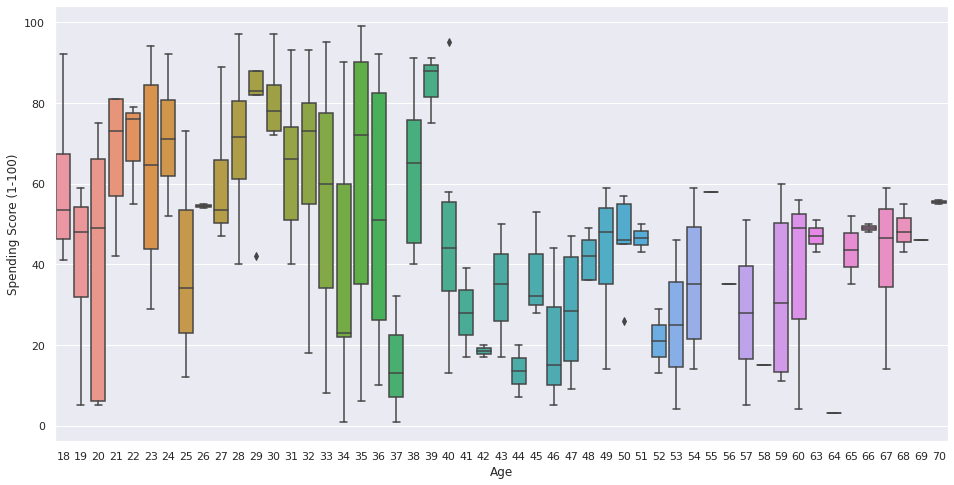

In [9]:
# Boxplot relation
import seaborn as sns
plt.figure(figsize=(16,8))
sns.boxplot(x ='Age',y ='Spending Score (1-100)',data=df)
plt.show()

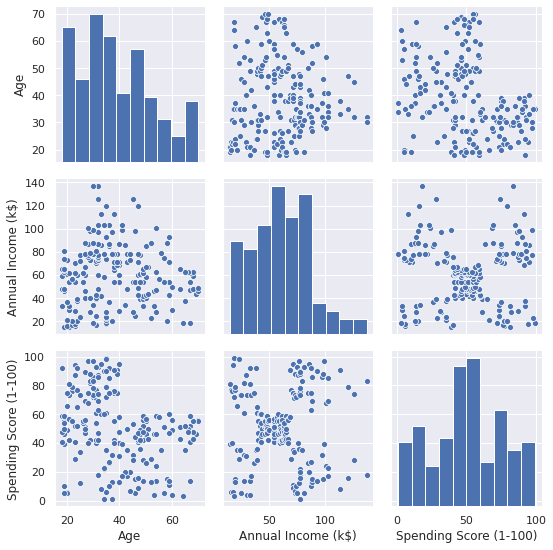

In [10]:
sns.pairplot(df,kind='scatter')

What we understand is data is clean and normally distributed. It would be helpful for clustering

#### Data cleaning

In [0]:
def normalization(X):
  '''
   This function takes dataframe values to be normalized and normalizes it within the range 0 and 1

  '''
  X_ori = X    # For storing to normalise
  X = (X_ori-X_ori.min())/(X_ori.max()-X_ori.min())   # Normalised values
  return X

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler as std
def one_hot_encoding(df, column_name):
    """
    Creates instance of one-hot-encoder and removes original column 
    as well as first column to avoid dummy trap

    """
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of column_types)
    enc_df = pd.DataFrame(enc.fit_transform(df[[column_name]]).toarray())
    enc_df = enc_df.add_prefix('OH_')
    # drop the column first to avoid dummy traps
    enc_df.drop(enc_df.columns[1], axis=1, inplace = True)
    # merge with main df enc_df on key values
    df = df.join(enc_df)
    # drop the original column
    df.drop(column_name, axis = 1, inplace = True)
  
    return df

Normalised the continous variables and one hot encoded the categorical variables

In [0]:
df = one_hot_encoding(df,'Gender')
X = df.drop("OH_0", axis = 1)

# For standardization
scaler=std()
X = scaler.fit_transform(X)
X = np.hstack((X,df['OH_0'].values.reshape(-1,1)))
# For normalization
# df = normalization(X).join(df['OH_0'])

#### Clustering 

> Clustering is done here with the help of following set of algorithms:
  - KMeans
  - Agglomerative clustering
     - Hierarchial clustering
     - DB scan clustering

##### Metric for evalution
1. **Davies–Bouldin index (DBI)**: DBI index is used for evaluating the performance of clustering. This is an internal evaluation scheme, where the validation of how well the clustering has been done is made using quantities and features inherent to the dataset.

$$ S_i = \Bigg( \frac{1}{T_i}\displaystyle\sum_{j=1}^{T_i}|X_j - A_i|^p\Bigg)^\frac{1}{p}$$
here A is the centroid of C and T is the size of the cluster i. S is a     measure of scatter within the cluster for every point i. p is power where p = 2 means euclidean norm
           
                  
2.   **Silthouette coefficient**: This method is specifically used in K-means clustering. It can be defined as ratio of mean intracluster distance (a) and mean nearest cluster distance (b)

$$ S(t) = \frac{b - a}{max(a,b)} $$



The following library has all the validation tests and algorithms to perform clustering

In [0]:
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering,DBSCAN,KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
class clustering:
  """
   This class has all the tests of clustering criterion to find the optimal number of clusters
   and all the clustering methods to do clustering

   Clustering methods dicussed over here are:

    1.  Agglomerative clustering
         1.1) Hierarchial clustering
         1.2) DB scan clustering

    2.  K-means clustering

  """

  def __init__(self, X):
    
    self.X = X

  def cluster_plot(self):
       """
        Cluster plotting for different cluster algorithms
       """
       fig = plt.figure(figsize=(10,8))
       sns.set_palette(sns.color_palette("cubehelix", 8))
       ax = Axes3D(fig)
       ax.scatter(self.X[:,0].tolist(),self.X[:,1].tolist(),self.X[:,2].tolist(),c=self.labels,marker='v')
       ax.legend()
       plt.show()

  def dendogram(self):
      """
      This method plots dendogram for hierarchial clustering
      """
      plt.figure(figsize=(20, 7))
      dendrogram = sch.dendrogram(sch.linkage(self.X, method='ward'))
      plt.title("Dendograms")
      plt.axhline(linestyle='--', y=5) 
      plt.show()
  
  def silhouette_scores(self):
      """
      This method plots silhouette_scores for k-means clustering to find optimal number of clusters

      """
      kmeans_models = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
      silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_models[1:]]
      print("The maximum silhouette score is %0.02f at the cluster number %d\n" % (np.max(silhouette_scores),(silhouette_scores.index(np.max(silhouette_scores))+2)))
      plt.figure(figsize=(16, 8))
      plt.plot(range(2, 10), silhouette_scores, "bo-")
      plt.xlabel("$k$", fontsize=14)
      plt.ylabel("Silhouette score", fontsize=14)
      plt.show()


  def davies_bouldin_score(self):
     """
     Validation test to check score after clustering

     """
     print("The davies bouldin score of the clustering is %0.002f\n" % (davies_bouldin_score(self.X, self.labels)))
     print("The points in each cluster are : ")
     print(collections.Counter(self.labels))


  def kmeans_clustering(self,k):

     """
     Performs k-means algorithm with given clusters'k'

     Input  : The input to this algorithm is clusters
     Output : Output is clustering labels
     """
     print("***Performing K-means clustering with %d clusters***\n"%k)
     kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=100, n_jobs=-1).fit(X)
     self.labels = kmeans.labels_
     self.davies_bouldin_score()
     print("The k-means inertia is %0.002f\n" %(kmeans.inertia_))
     self.cluster_plot()
     return self.labels , kmeans.cluster_centers_


  def hierarchial_clustering(self,k):

       """
       Performs hierarchial clustering with given clusters'k'

       Input  : The input to this algorithm are clusters
       Output : Output is clustering labels
       """
       print("***Performing hierarchial clustering***\n")
       self.clustering = AgglomerativeClustering(affinity='euclidean', linkage='ward').fit(X)
       self.labels = self.clustering.labels_
       self.davies_bouldin_score()
       print("The number of cluster centers formed are %d\n" % (self.clustering.n_clusters_))
       self.cluster_plot()
       return self.labels


  def DBscan_clustering(self,d,s):

       """
       Performs DBscan clustering with given distance 'd' and 'sample size 's'

       Input  : The input to this algorithm is clustering distance and samples
       Output : Output is clustering labels
       """
       print("***Performing agglomerative clustering***\n")
       self.clustering = DBSCAN(eps=d,min_samples=s,metric = 'euclidean').fit(X)
       self.labels = self.clustering.labels_
       self.davies_bouldin_score()
       print("The number of cluster centers formed are %d\n" % len(np.unique(self.labels)))
       self.cluster_plot()
       return self.labels

**Let's do clustering one by one**

##### $Hierarchial clustering$

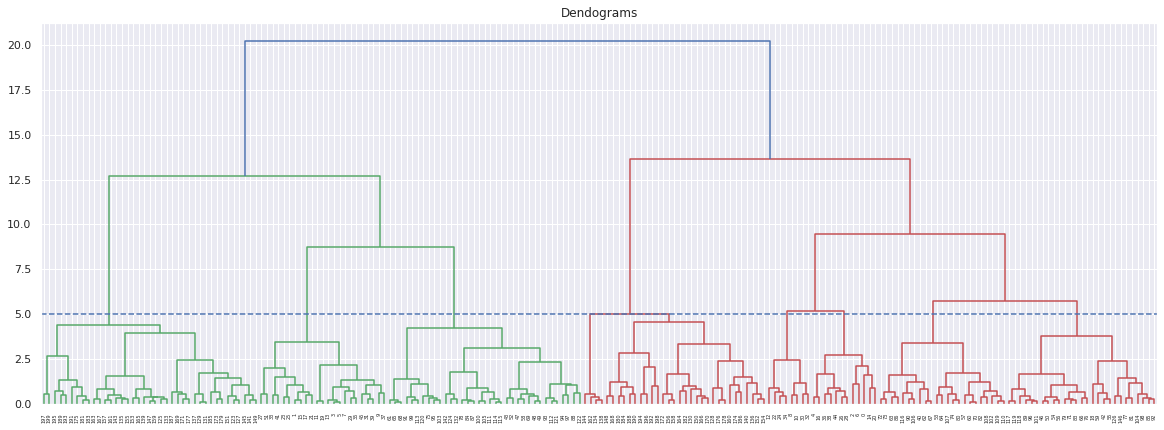

In [14]:
#X = df
c = clustering(X)
c.dendogram()

No handles with labels found to put in legend.


***Performing hierarchial clustering***

The davies bouldin score of the clustering is 1.39

The points in each cluster are : 
Counter({0: 103, 1: 97})
The number of cluster centers formed are 2



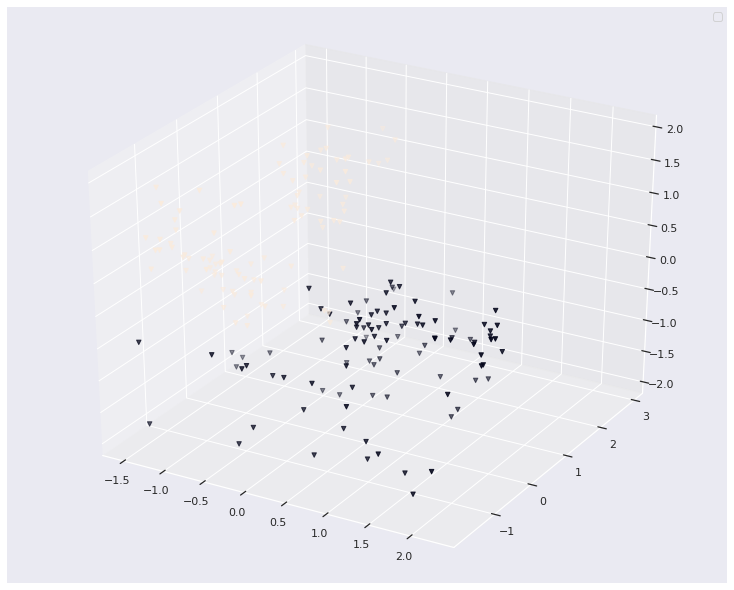

In [15]:
# Let's do some agglomerative clustering from the dendogram it appears ideal cluster size is 6
labels = c.hierarchial_clustering(6)

##### $DBscan  clustering$

No handles with labels found to put in legend.


***Performing agglomerative clustering***

The davies bouldin score of the clustering is 2.30

The points in each cluster are : 
Counter({-1: 106, 0: 23, 2: 22, 1: 21, 4: 18, 3: 10})
The number of cluster centers formed are 6



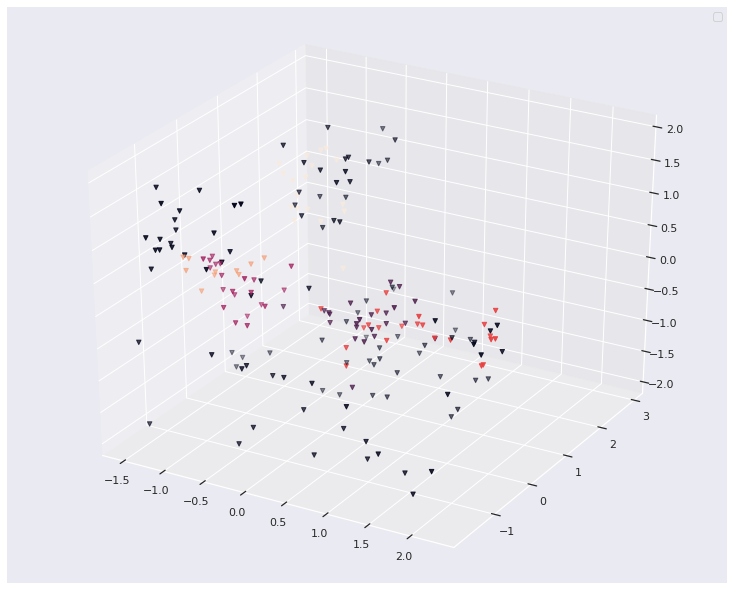

In [16]:
labels = c.DBscan_clustering(0.7,10)

##### $Kmeans clustering$

The maximum silhouette score is 0.36 at the cluster number 6



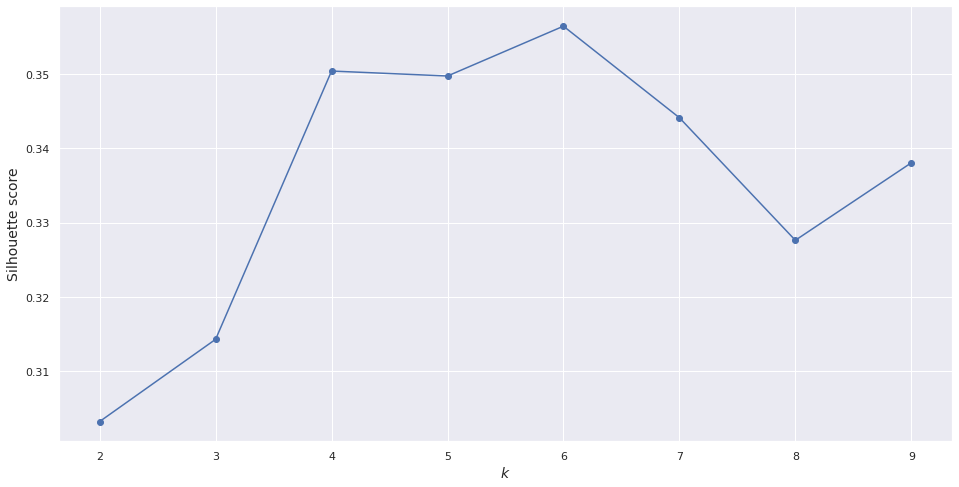

In [17]:
c.silhouette_scores()

***Performing K-means clustering with 6 clusters***



No handles with labels found to put in legend.


The davies bouldin score of the clustering is 1.01

The points in each cluster are : 
Counter({0: 45, 1: 39, 5: 38, 2: 34, 3: 23, 4: 21})
The k-means inertia is 181.95



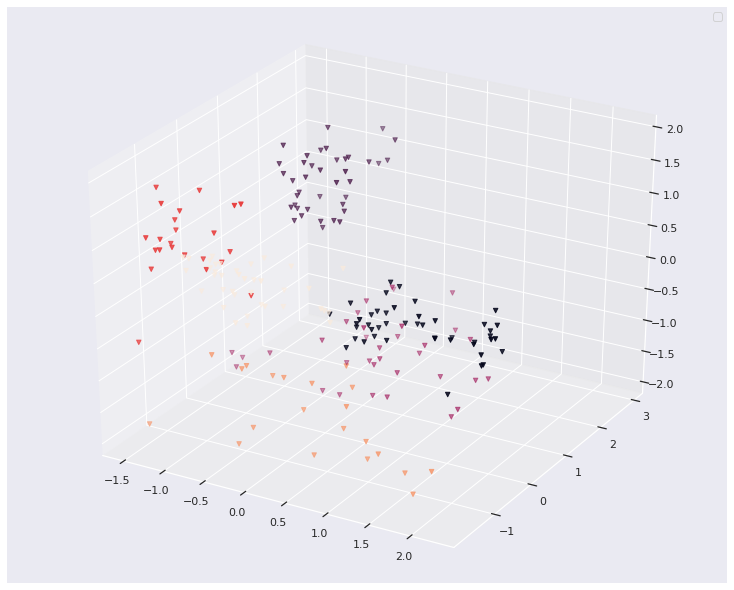

In [18]:
# Since silhouette score is more at value of cluster 6
labels , centers = c.kmeans_clustering(6)